In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import numpy as np
from sklearn import preprocessing
import data_process
import data_load

DATA_PATH = "../data/Turbine_Data_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv"
LOGS_PATH = "../data/Status_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv"

data = data_load.load_turbine_data_without_time(DATA_PATH)
logs = data_load.load_turbine_logs_with_endtime(LOGS_PATH)
labels = data_load.get_data_label(data_load.load_turbine_data(DATA_PATH), logs)
scaler = preprocessing.StandardScaler()
data = data_process.impute_data(data)
data = data_process.standardize_data(data, scaler=scaler)
print(data.shape)
data = np.array(data, dtype='float32')

(26064, 299)


In [3]:
from torch import nn
from cnn import train_model, model
from sklearn.model_selection import train_test_split

X, y = data_process.split_data_into_windows(data, labels, 100)
print(np.shape(X), np.shape(y))

epochs = 100
k = 10

i = 0
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# X_train = X_train[y_train == 0]

cnn_model = model.CNN(feature_num=np.size(data, axis=1)).to(device)
loss = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(ae_model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0015)

for epoch in range(epochs):
    print(f"\n=====epoch {epoch}/{epochs}=====")
    train_model.cnn_train(train_X=X_train, train_y=y_train, model=cnn_model, loss_fn=loss, optimizer=optimizer,
                      batch_size=2000)


(25963, 299, 100) (25963,)

=====epoch 0/100=====
range(0, 12, 2)
loss: 0.746787  [ 2000/23366]
loss: 0.734596  [ 6000/23366]
loss: 0.724116  [10000/23366]
loss: 0.713598  [14000/23366]
loss: 0.704143  [18000/23366]
loss: 0.698769  [22000/23366]

=====epoch 1/100=====
range(0, 12, 2)
loss: 0.695729  [ 2000/23366]
loss: 0.694425  [ 6000/23366]
loss: 0.693790  [10000/23366]
loss: 0.693423  [14000/23366]
loss: 0.693270  [18000/23366]
loss: 0.693215  [22000/23366]

=====epoch 2/100=====
range(0, 12, 2)
loss: 0.693156  [ 2000/23366]
loss: 0.693143  [ 6000/23366]
loss: 0.693168  [10000/23366]
loss: 0.693156  [14000/23366]
loss: 0.693140  [18000/23366]
loss: 0.693168  [22000/23366]

=====epoch 3/100=====
range(0, 12, 2)
loss: 0.693125  [ 2000/23366]
loss: 0.693136  [ 6000/23366]
loss: 0.693132  [10000/23366]
loss: 0.693040  [14000/23366]
loss: 0.692841  [18000/23366]
loss: 0.691831  [22000/23366]

=====epoch 4/100=====
range(0, 12, 2)
loss: 0.688505  [ 2000/23366]
loss: 0.681559  [ 6000/23366

torch.Size([2597, 2])


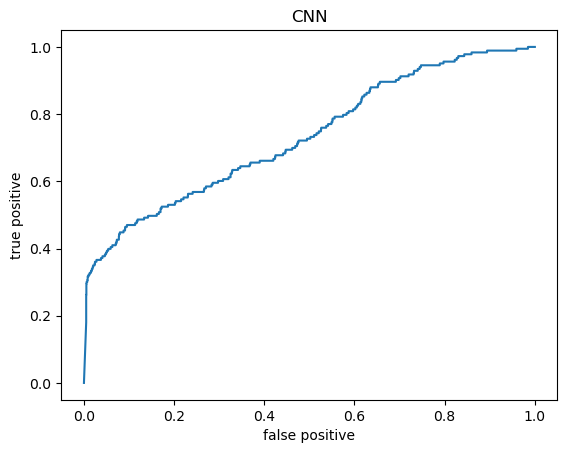

0.7323490929505028


In [4]:
from matplotlib import pyplot as plt
import sklearn.metrics as metrics

res = train_model.cnn_test(X_test, cnn_model)
print(np.shape(res))

softmax = nn.Softmax(dim=1)

res = softmax(res)[:,1].cpu().detach().numpy()

# print(res)

fpr, tpr, _ = metrics.roc_curve(y_test, res)

plt.plot(fpr, tpr)
plt.xlabel("false positive")
plt.ylabel("true positive")
plt.title("CNN")
plt.show()
print(metrics.auc(fpr, tpr))



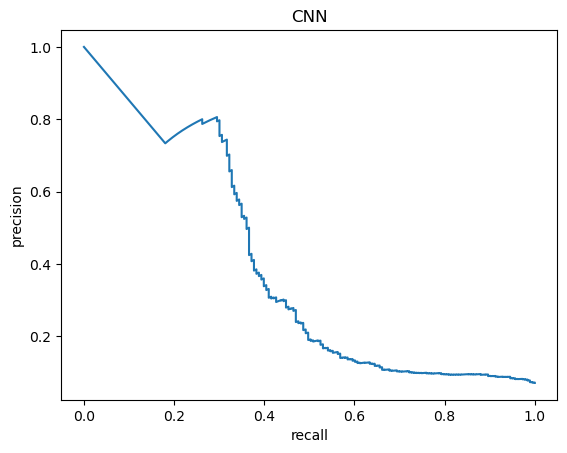

In [5]:
precision, recall, threshold = metrics.precision_recall_curve(y_test, res)
plt.plot(recall, precision)

plt.ylabel("precision")
plt.xlabel("recall")
plt.title("CNN")
plt.show()